<a href="https://colab.research.google.com/github/Noob-Coder2/Network-Traffic-Prediction/blob/main/Federated_Learning_Model_(No_Chat_%2B_Quantile_Transform).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

We install Flower and a compatible version of TensorFlow.

In [ ]:
!pip install -q flwr[simulation] tensorflow

### Mount Google Drive

This gives the notebook access to your project folder for loading data and saving model weights.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

Import all necessary libraries for the project.

In [ ]:
import flwr as fl
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("TensorFlow Version:", tf.__version__)
print("Flower Version:", fl.__version__)


TensorFlow Version: 2.19.0
Flower Version: 1.20.0


### Data Loading and Advanced Preprocessing

This cell contains the final, successful preprocessing pipeline.

In [ ]:

# --- Define paths and load data from your Drive ---
DRIVE_PATH = '/content/drive/MyDrive/Network Application Prediction/'
DATASET_PATH = os.path.join(DRIVE_PATH, 'consolidated_NonVPN.csv')
WEIGHTS_PATH = os.path.join(DRIVE_PATH, 'federated_model_weights_no_chat.npy') # Using a new weights file

try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully from '{DATASET_PATH}'.")
except FileNotFoundError:
    print(f"Error: Dataset not found at '{DATASET_PATH}'. Please check the path.")
    df = pd.DataFrame()

if not df.empty:
    # --- KEY CHANGE: Remove the noisy 'CHAT' class ---
    print(f"\nOriginal dataset size: {len(df)}")
    df = df[df['traffic_type'] != 'CHAT'].copy()
    print(f"Dataset size after removing 'CHAT' class: {len(df)}")

    # 1. Initial Feature Engineering
    epsilon = 1e-6
    df['avg_packet_size'] = df['flowBytesPerSecond'] / (df['flowPktsPerSecond'] + epsilon)
    df['active_idle_ratio'] = df['mean_active'] / (df['mean_idle'] + epsilon)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # 2. Label Encoding for the target
    label_encoder = LabelEncoder()
    df['traffic_type_encoded'] = label_encoder.fit_transform(df['traffic_type'])
    num_classes = len(label_encoder.classes_)
    print(f"\nFound {num_classes} unique traffic types after removal.")

    # 3. Separate features and target
    X_features = df.drop(columns=['traffic_type', 'traffic_type_encoded'])
    y = df['traffic_type_encoded']

    # 4. Apply Quantile Transformation
    print("Applying Quantile Transformation...")
    qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(X_features)-1))
    X_final = pd.DataFrame(qt.fit_transform(X_features), columns=X_features.columns)

    # 5. Align indices before splitting
    y.reset_index(drop=True, inplace=True)
    X_final.reset_index(drop=True, inplace=True)

    # 6. Data Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_final.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_final.columns)
    print("\nPreprocessing complete.")
    print(f"Final training set shape: {X_train.shape}")


Dataset loaded successfully from '/content/drive/MyDrive/Network Application Prediction/consolidated_NonVPN.csv'.

Original dataset size: 29613
Dataset size after removing 'CHAT' class: 27108

Found 6 unique traffic types after removal.
Applying Quantile Transformation...

Preprocessing complete.
Final training set shape: (21686, 25)


### Comprehensive Exploratory Data Analysis (EDA)

This cell provides a deep dive into the preprocessed training data.


--- Starting Comprehensive EDA on Preprocessed Training Data ---

--- Univariate Analysis ---


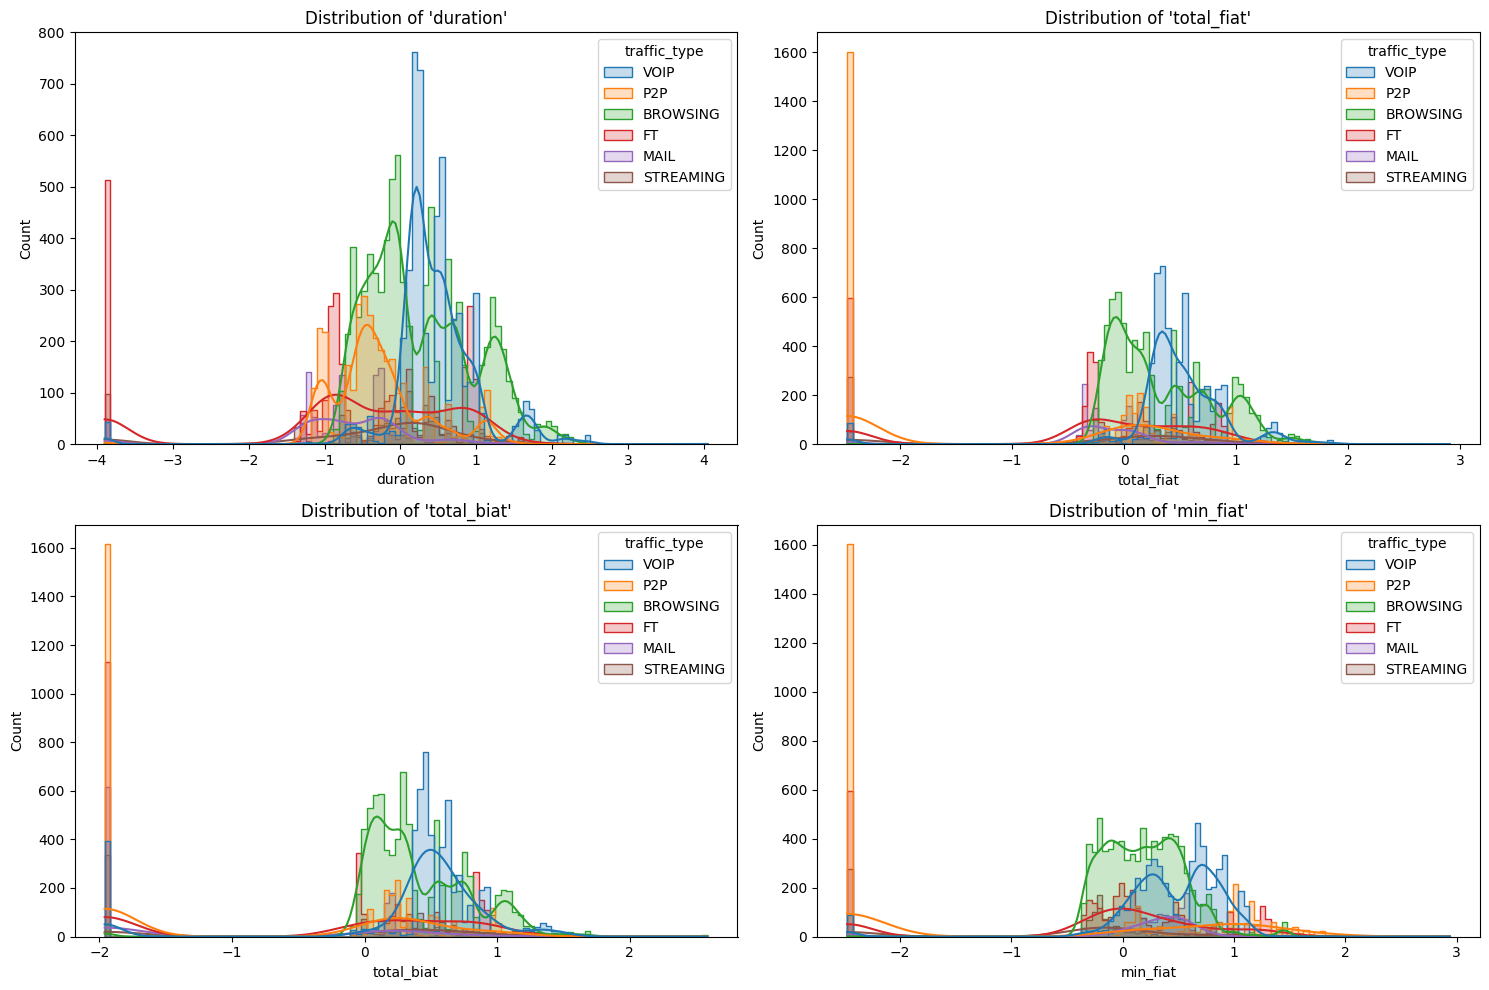


--- Multivariate Analysis ---

Running t-SNE for multivariate visualization (may take a few minutes)...


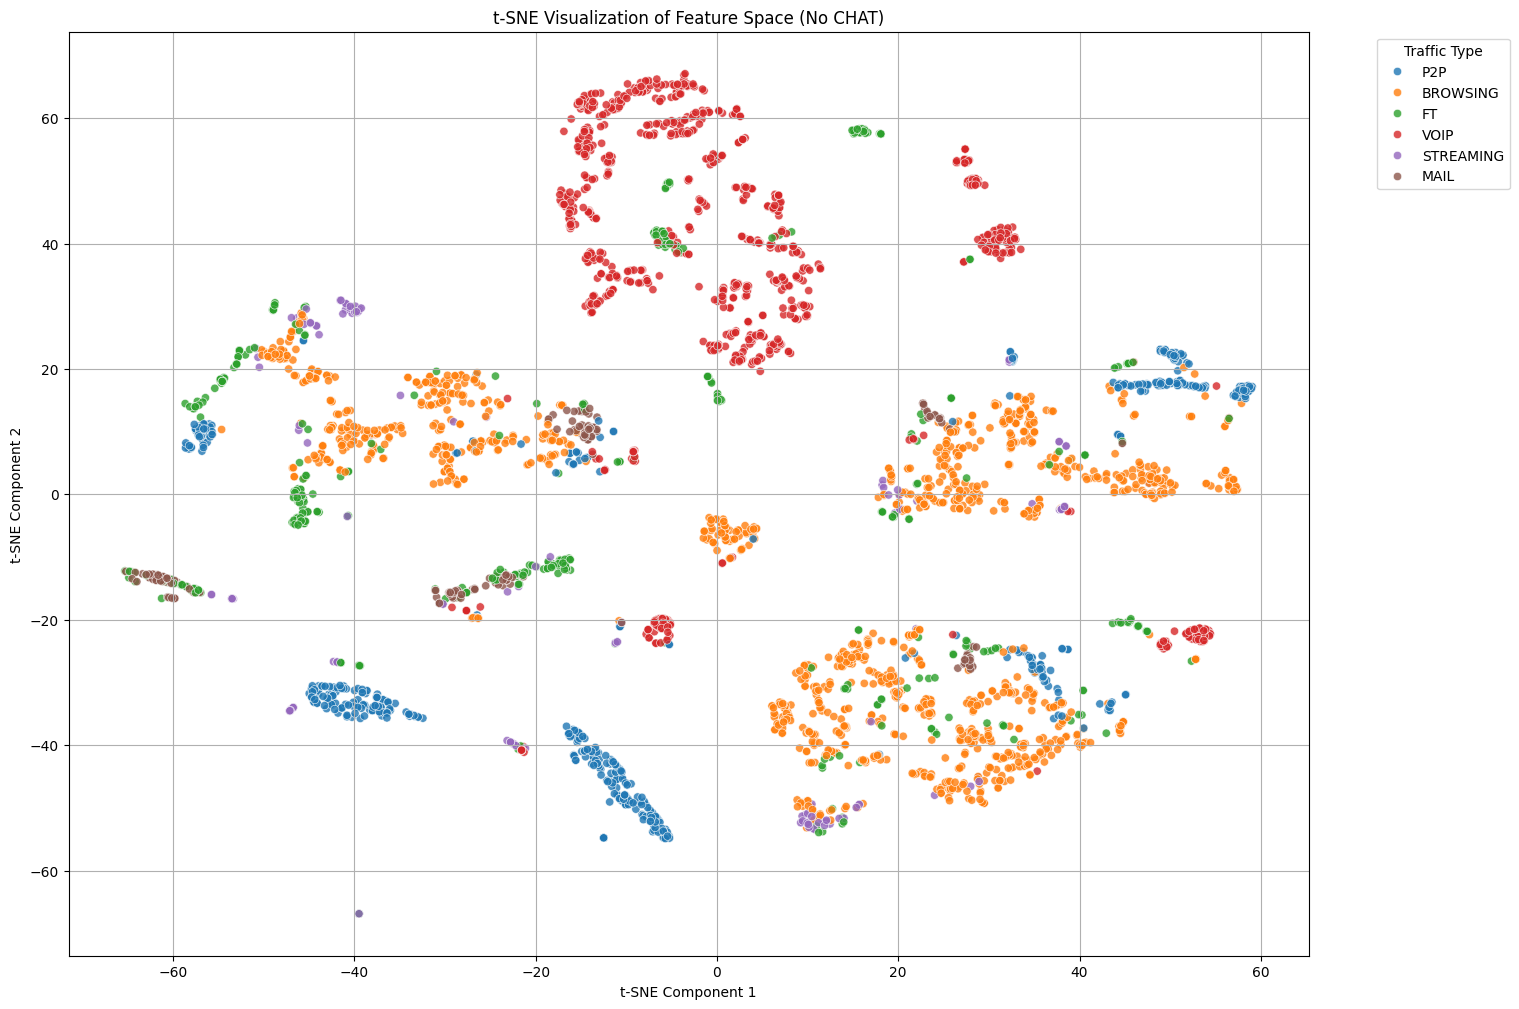

In [ ]:

print("\n--- Starting Comprehensive EDA on Preprocessed Training Data ---")
if not df.empty:
    # Combine the processed training features and labels for plotting
    eda_df = X_train.copy()
    eda_df['traffic_type'] = label_encoder.inverse_transform(y_train)

    # --- 1. Univariate Analysis: Feature Distributions ---
    print("\n--- Univariate Analysis ---")
    top_4_features = X_final.columns[:4]
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_4_features):
        plt.subplot(2, 2, i + 1)
        sns.histplot(data=eda_df, x=feature, kde=True, hue='traffic_type', palette='tab10', element="step")
        plt.title(f"Distribution of '{feature}'")
    plt.tight_layout()
    plt.show()

    # --- 2. Multivariate Analysis ---
    print("\n--- Multivariate Analysis ---")

    # t-SNE Multivariate Visualization
    print("\nRunning t-SNE for multivariate visualization (may take a few minutes)...")
    tsne_sample = eda_df.sample(n=min(4000, len(eda_df)), random_state=42)
    X_sample = tsne_sample.drop(columns=['traffic_type'])
    y_sample_labels = tsne_sample['traffic_type']

    tsne = TSNE(n_components=2, perplexity=40, random_state=42, max_iter=1000)
    tsne_results = tsne.fit_transform(X_sample)

    tsne_df = pd.DataFrame({'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1], 'label': y_sample_labels})

    plt.figure(figsize=(16, 12))
    sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", palette="tab10", data=tsne_df, legend="full", alpha=0.8)
    plt.title('t-SNE Visualization of Feature Space (No CHAT)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Traffic Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


### Define ResNet Model and Flower Client (for FedAvg)

This cell defines the robust ResNet architecture and a standard client for FedAvg.

In [ ]:

def resnet_block(input_layer, units, dropout_rate=0.3):
    from tensorflow.keras import layers
    x = layers.Dense(units)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Dense(units)(input_layer)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def create_resnet_model():
    from tensorflow.keras import layers
    num_features = X_train.shape[1]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    inputs = layers.Input(shape=(num_features,))
    x = resnet_block(inputs, units=64)
    x = resnet_block(x, units=32)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.model = create_resnet_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        # Using 2 local epochs, which proved effective
        self.model.fit(self.x_train, self.y_train, epochs=2, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_train, self.y_train, verbose=0)
        return loss, len(self.x_train), {"accuracy": accuracy}

print("\nResNet model and FedAvg-compatible Flower client defined.")



ResNet model and FedAvg-compatible Flower client defined.


### Prepare the Simulation (with Persistence)

This cell sets up the simulation environment.

In [ ]:
NUM_CLIENTS = 20
NUM_ROUNDS = 10

final_model_predictions = None
client_manager = fl.server.client_manager.SimpleClientManager()

def client_fn(cid: str) -> FlowerClient:
    client_data = client_partitions[int(cid)]
    x_client = client_data.drop(columns=['traffic_type_encoded'])
    y_client = client_data['traffic_type_encoded'].astype(int)
    return FlowerClient(x_client.values, y_client.values)

def get_evaluate_fn():
    """Returns a server-side evaluation function that saves weights every round."""
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: dict):
        global final_model_predictions
        model = create_resnet_model()
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(X_test.values, y_test.values, verbose=0)

        print(f"\nSaving model weights for round {server_round} to '{WEIGHTS_PATH}'...")
        np.save(WEIGHTS_PATH, np.array(parameters, dtype=object), allow_pickle=True)

        if server_round == NUM_ROUNDS:
             print(f"Capturing predictions from final model (Round {server_round})...")
             y_pred_probs = model.predict(X_test.values)
             final_model_predictions = np.argmax(y_pred_probs, axis=1)
        return loss, {"accuracy": accuracy}
    return evaluate

# Load weights for a "warm start"
if os.path.exists(WEIGHTS_PATH) and os.path.getsize(WEIGHTS_PATH) > 0:
    print(f"Found existing weights at '{WEIGHTS_PATH}'. Loading for warm start.")
    saved_weights = np.load(WEIGHTS_PATH, allow_pickle=True)
    initial_parameters = fl.common.ndarrays_to_parameters(list(saved_weights))
else:
    if os.path.exists(WEIGHTS_PATH):
        print(f"Warning: Found corrupted or empty weights file at '{WEIGHTS_PATH}'. Re-initializing.")
    else:
        print("No saved weights found. Initializing model from scratch.")

    initial_model = create_resnet_model()
    initial_weights = initial_model.get_weights()
    np.save(WEIGHTS_PATH, np.array(initial_weights, dtype=object), allow_pickle=True)
    initial_parameters = fl.common.ndarrays_to_parameters(initial_weights)

strategy = fl.server.strategy.FedAvg(
    evaluate_fn=get_evaluate_fn(),
    min_fit_clients=5,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=initial_parameters,
)

print("Simulation components ready for non-Ray execution with FedAvg and persistence.")


Found existing weights at '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'. Loading for warm start.
Simulation components ready for non-Ray execution with FedAvg and persistence.


### Start the Federated Learning Simulation

This cell runs the main federated training loop.

In [ ]:

if not df.empty:
    print("\nStarting Federated Learning simulation...")

    combined_train_df = X_train.copy()
    combined_train_df['traffic_type_encoded'] = y_train
    client_partitions = np.array_split(combined_train_df, NUM_CLIENTS)

    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        strategy=strategy,
        client_manager=client_manager
    )
    print("Simulation finished.")
else:
    print("\nSkipping simulation because data was not loaded.")


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout



Starting Federated Learning simulation...


2025-08-11 10:46:07,892	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7989822260.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3994911129.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.33345842361450195, {'accuracy': 0.8943194150924683}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 20 clients (out of 20)



Saving model weights for round 0 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(pid=25775) 2025-08-11 10:46:17.930240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25775) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=25775) E0000 00:00:1754909178.228111   25775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25775) E0000 00:00:1754909178.313061   25775 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=25775) W0000 00:00:1754909178.510153   25775 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=25775) W0000 00:00:1754909178.510192   25775 computation_placer.cc:177] computation placer already registered.


Saving model weights for round 1 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25774) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25774)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25774)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=25774) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned


Saving model weights for round 2 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25774) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientApp


Saving model weights for round 3 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientApp


Saving model weights for round 4 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientApp


Saving model weights for round 5 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientApp


Saving model weights for round 6 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25774) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an ins


Saving model weights for round 7 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25774) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25774)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25774)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientApp


Saving model weights for round 8 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientApp


Saving model weights for round 9 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...


(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=25774) 
(ClientAppActor pid=25774)         
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an ins


Saving model weights for round 10 to '/content/drive/MyDrive/Network Application Prediction/federated_model_weights_no_chat.npy'...
Capturing predictions from final model (Round 10)...
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


INFO :      fit progress: (10, 0.26551759243011475, {'accuracy': 0.9158982038497925}, 1247.106545783)
INFO :      configure_evaluate: strategy sampled 20 clients (out of 20)
(ClientAppActor pid=25775) 
(ClientAppActor pid=25775)         
(ClientAppActor pid=25775) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=25775)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=25775)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=25775) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Cl

Simulation finished.


### Final Model Evaluation & Visualization

This cell performs a full analysis using the captured predictions.

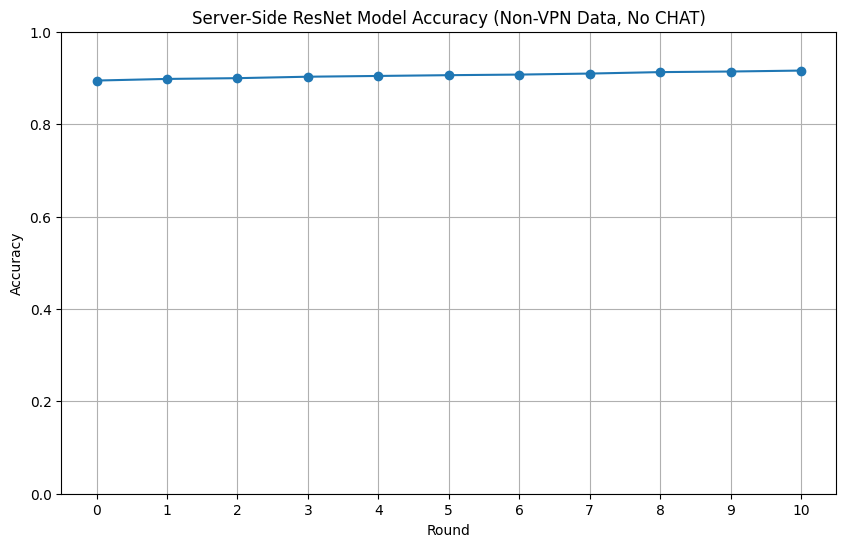


--- Final Federated Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

    BROWSING       0.93      0.97      0.95      2000
          FT       0.87      0.79      0.83       795
        MAIL       0.70      0.82      0.75       273
         P2P       0.96      0.93      0.94       800
   STREAMING       0.78      0.68      0.73       257
        VOIP       0.97      0.97      0.97      1297

    accuracy                           0.92      5422
   macro avg       0.87      0.86      0.86      5422
weighted avg       0.92      0.92      0.92      5422



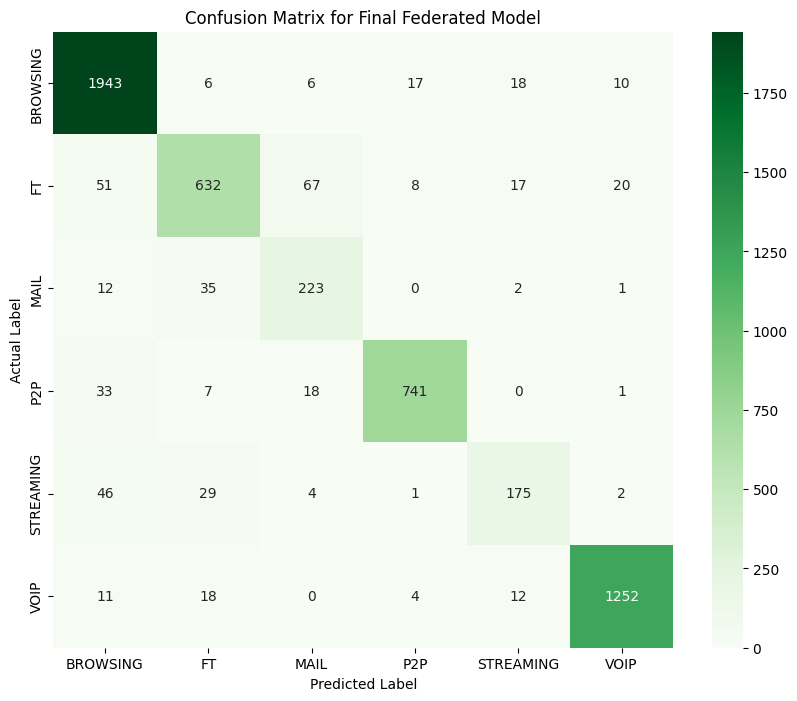

In [ ]:
if not df.empty and 'history' in locals() and history.metrics_centralized:
    # 1. Plot the accuracy over rounds
    accuracy_data = history.metrics_centralized["accuracy"]
    rounds = [item[0] for item in accuracy_data]
    accuracies = [item[1] for item in accuracy_data]

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, accuracies, marker='o', linestyle='-')
    plt.title("Server-Side ResNet Model Accuracy (Non-VPN Data, No CHAT)")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.xticks(rounds)
    plt.grid(True)
    plt.ylim(0, 1.0)
    plt.show()

    # 2. Generate detailed reports if predictions were captured
    if final_model_predictions is not None:
        print("\n--- Final Federated Model Evaluation ---")

        print("\nClassification Report:")
        print(classification_report(y_test, final_model_predictions, target_names=label_encoder.classes_))

        cm = confusion_matrix(y_test, final_model_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix for Final Federated Model')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("\nFinal predictions were not captured. Could not generate detailed report.")
else:
    print("\nNo results to analyze.")